In [155]:
import numpy as np
import keras
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import pandas as pd
from matplotlib import rc
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [156]:
GESTURES = [
    "A", "B", "C", "D", "E", "F", "G", "H", "I", "J",
    "K", "L","M", "N", "O", "P", "Q", "R", "S", "T",
    "U", "V","W", "X", "Y", "Z", "idle"
]

g = 9.81
column_mapping = {
    'column_0': 'ax',
    'column_1': 'ay',
    'column_2': 'az',
    'column_3': 'gx',
    'column_4': 'gy',
    'column_5': 'gz',
}

NUM_OF_RECORDINGS = 400
dfs_train = []
for label in GESTURES:
    for i in range(NUM_OF_RECORDINGS):
        df_train = pd.read_csv(f"csv/official/{label}/{label}_{i}.csv")
        df_train = df_train.rename(columns=column_mapping)
        df_train = df_train.iloc[14:85]
        df_train['label'] = label
        #normalize data by adding 4g to accelerometer data and divide by 8g
        df_train['ax'] = (df_train['ax'] + 4*g) / (8*g)
        df_train['ay'] = (df_train['ay'] + 4*g) / (8*g)
        df_train['az'] = (df_train['az'] + 4*g) / (8*g)
        #normalize data by dividing by 2000 deg/s
        df_train['gx'] = (df_train['gx'] + 2000) / 4000
        df_train['gy'] = (df_train['gy'] + 2000) / 4000
        df_train['gz'] = (df_train['gz'] + 2000) / 4000
        dfs_train.append(df_train)
df_train = pd.concat(dfs_train)

print (df_train.shape)

(554170, 7)


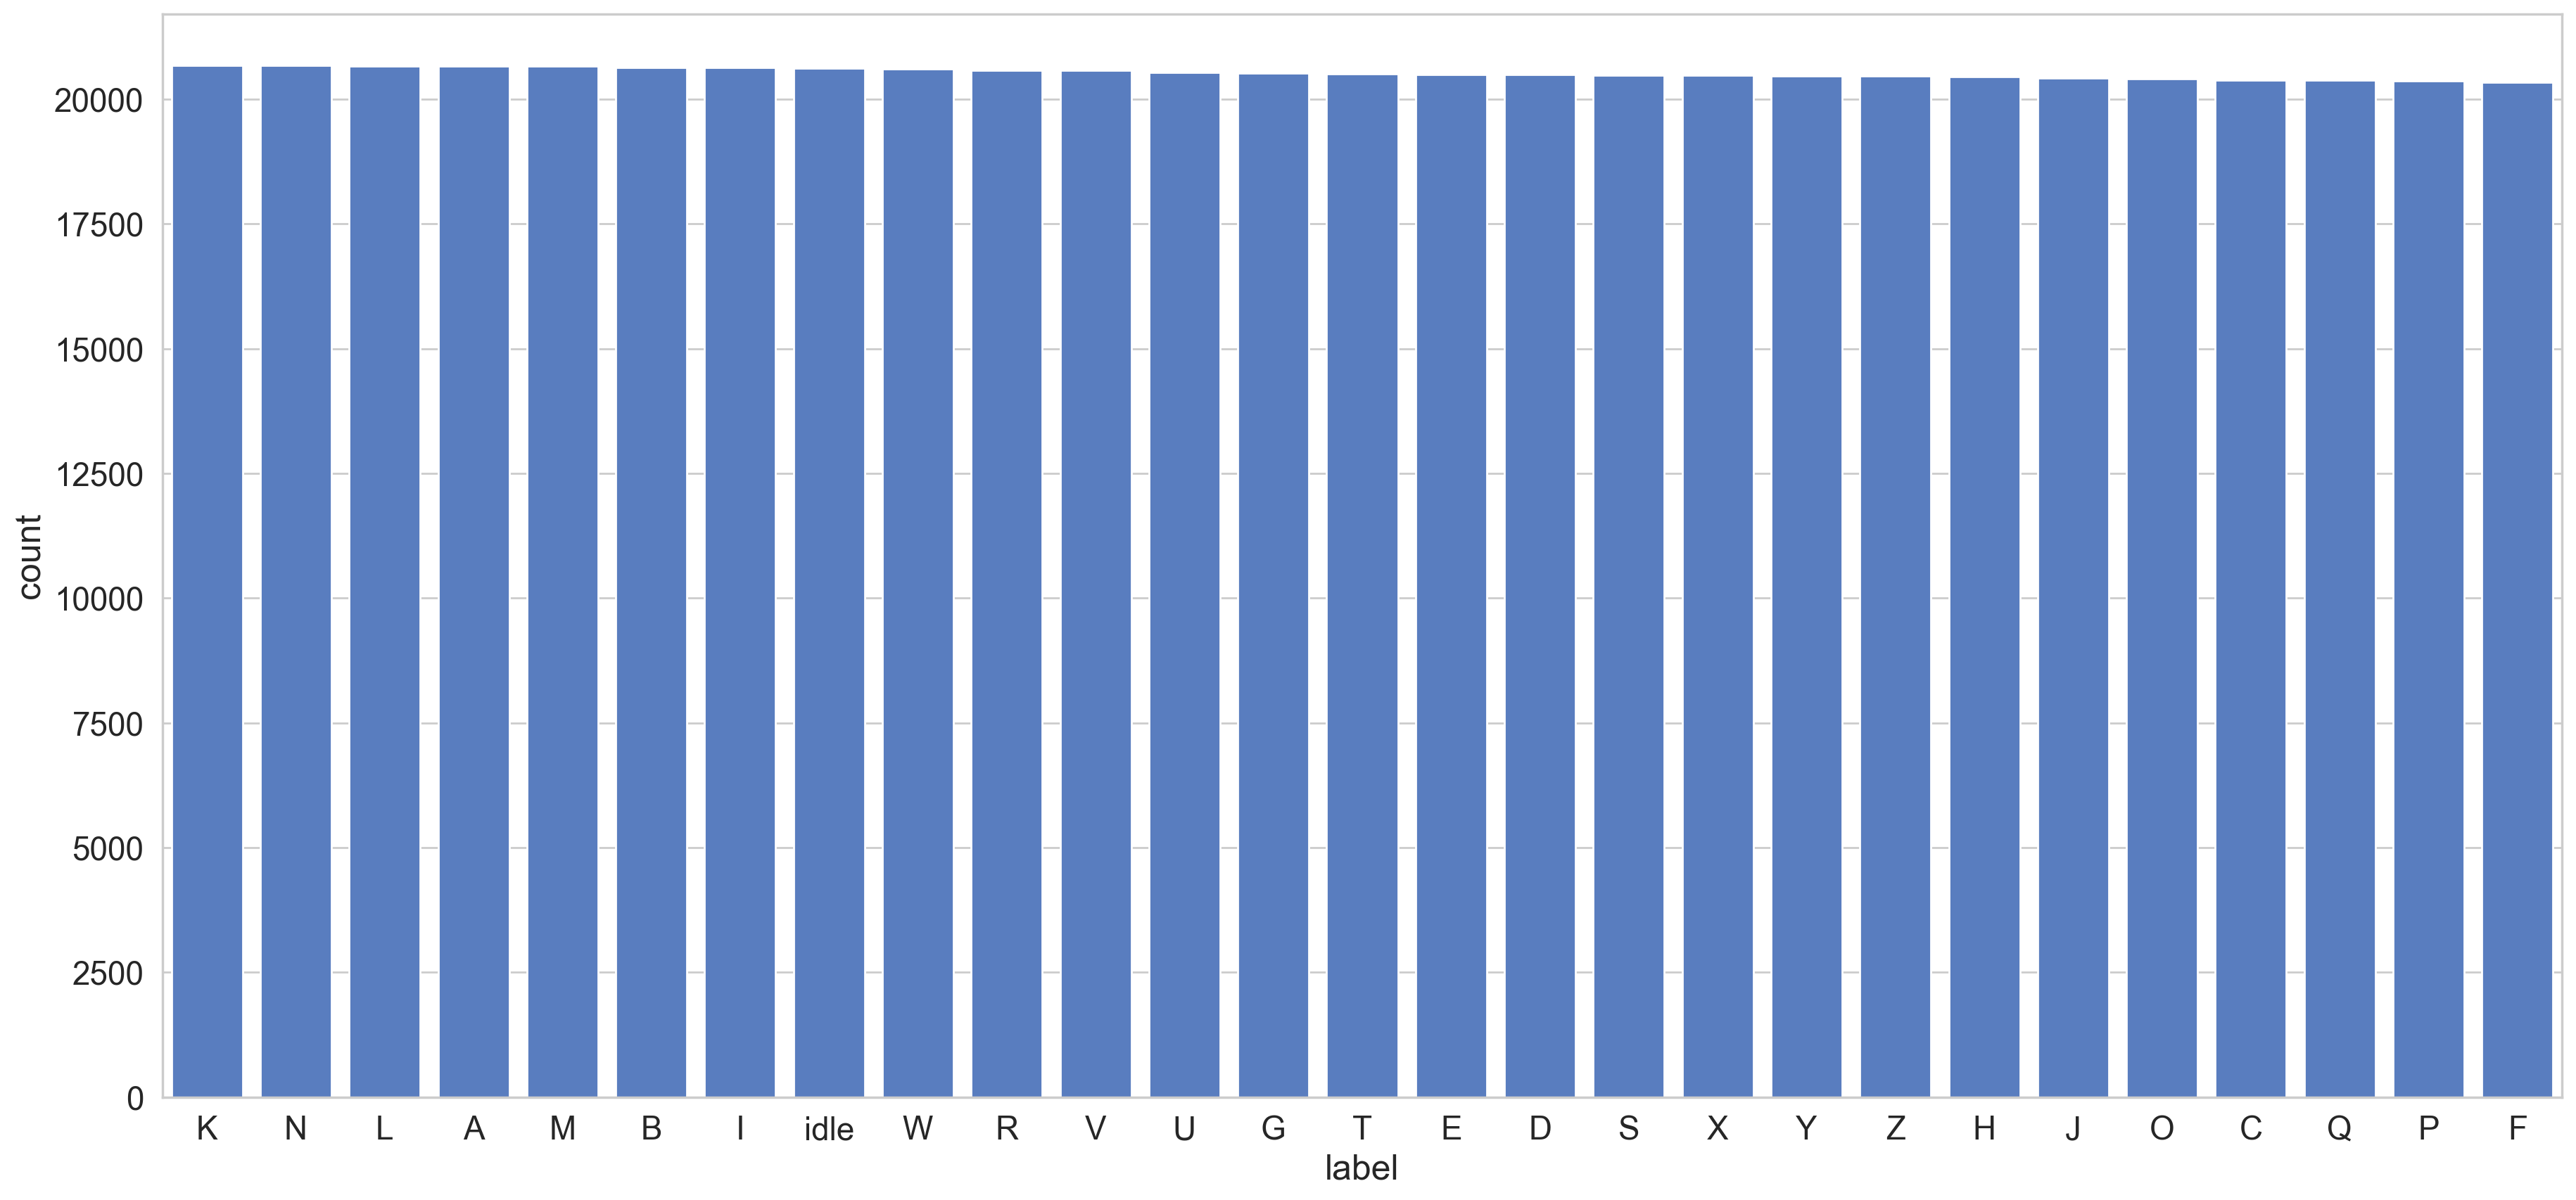

In [157]:
sns.countplot(x = 'label',
              data = df_train,
              order = df_train.label.value_counts().index);

In [158]:
def plot_label(label, df_train):
    data = df_train[df_train['label'] == label][['ax', 'ay', 'az','gx','gy','gz']][:70]
    axis = data.plot(subplots=True, figsize=(16, 12), title=label)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))

In [159]:
# for label in GESTURES:
#     plot_label(label, df_train)

In [160]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()

scaling_columns = ['ax', 'ay', 'az','gx','gy','gz']

df_train[scaling_columns] = scaler.fit_transform(df_train[scaling_columns])


In [168]:
from sklearn.model_selection import train_test_split
def create_dataset(X, y, time_steps=1, step=1):
    Xs, ys = [], []
    for i in range(0, len(X) - time_steps, step):
        v = X.iloc[i:(i + time_steps)].values
        labels = y.iloc[i: i + time_steps]
        Xs.append(v)        
        ys.append(np.unique(labels)[0])
    return np.array(Xs), np.array(ys).reshape(-1, 1)

TIME_STEPS = 70
STEP = 20

X_train, y_train = create_dataset(
    df_train[['ax', 'ay', 'az', 'gx', 'gy', 'gz']], 
    df_train.label, 
    TIME_STEPS, 
    STEP
)

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=RANDOM_SEED)

In [175]:
print(X_train.shape, y_train.shape)

(22164, 70, 6) (22164, 27)


In [169]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore', sparse=False)

enc = enc.fit(y_train)

y_train = enc.transform(y_train)
y_test = enc.transform(y_test)

C:\Users\duyho\AppData\Roaming\Python\Python311\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [176]:
print(X_test.shape, y_test.shape)

(5541, 70, 6) (5541, 27)


In [170]:
model = keras.Sequential()
model.add(
      keras.layers.LSTM(
          units=128, 
          input_shape=[X_train.shape[1], X_train.shape[2]]
      )
)
model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(y_train.shape[1], activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

In [172]:
history = model.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
)
model.summary()
model.save('lstm')

Epoch 1/5
174/174 [==============================] - 15s 87ms/step - loss: 0.5771 - acc: 0.8239
Epoch 2/5
174/174 [==============================] - 15s 87ms/step - loss: 0.3532 - acc: 0.8985
Epoch 3/5
174/174 [==============================] - 15s 86ms/step - loss: 0.2178 - acc: 0.9406
Epoch 4/5
174/174 [==============================] - 15s 87ms/step - loss: 0.1737 - acc: 0.9531
Epoch 5/5
174/174 [==============================] - 15s 89ms/step - loss: 0.1453 - acc: 0.9619
Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_15 (LSTM)              (None, 128)               69120     
                                                                 
 dropout_15 (Dropout)        (None, 128)               0         
                                                                 
 dense_30 (Dense)            (None, 100)               12900     
                                   

INFO:tensorflow:Assets written to: lstm\assets


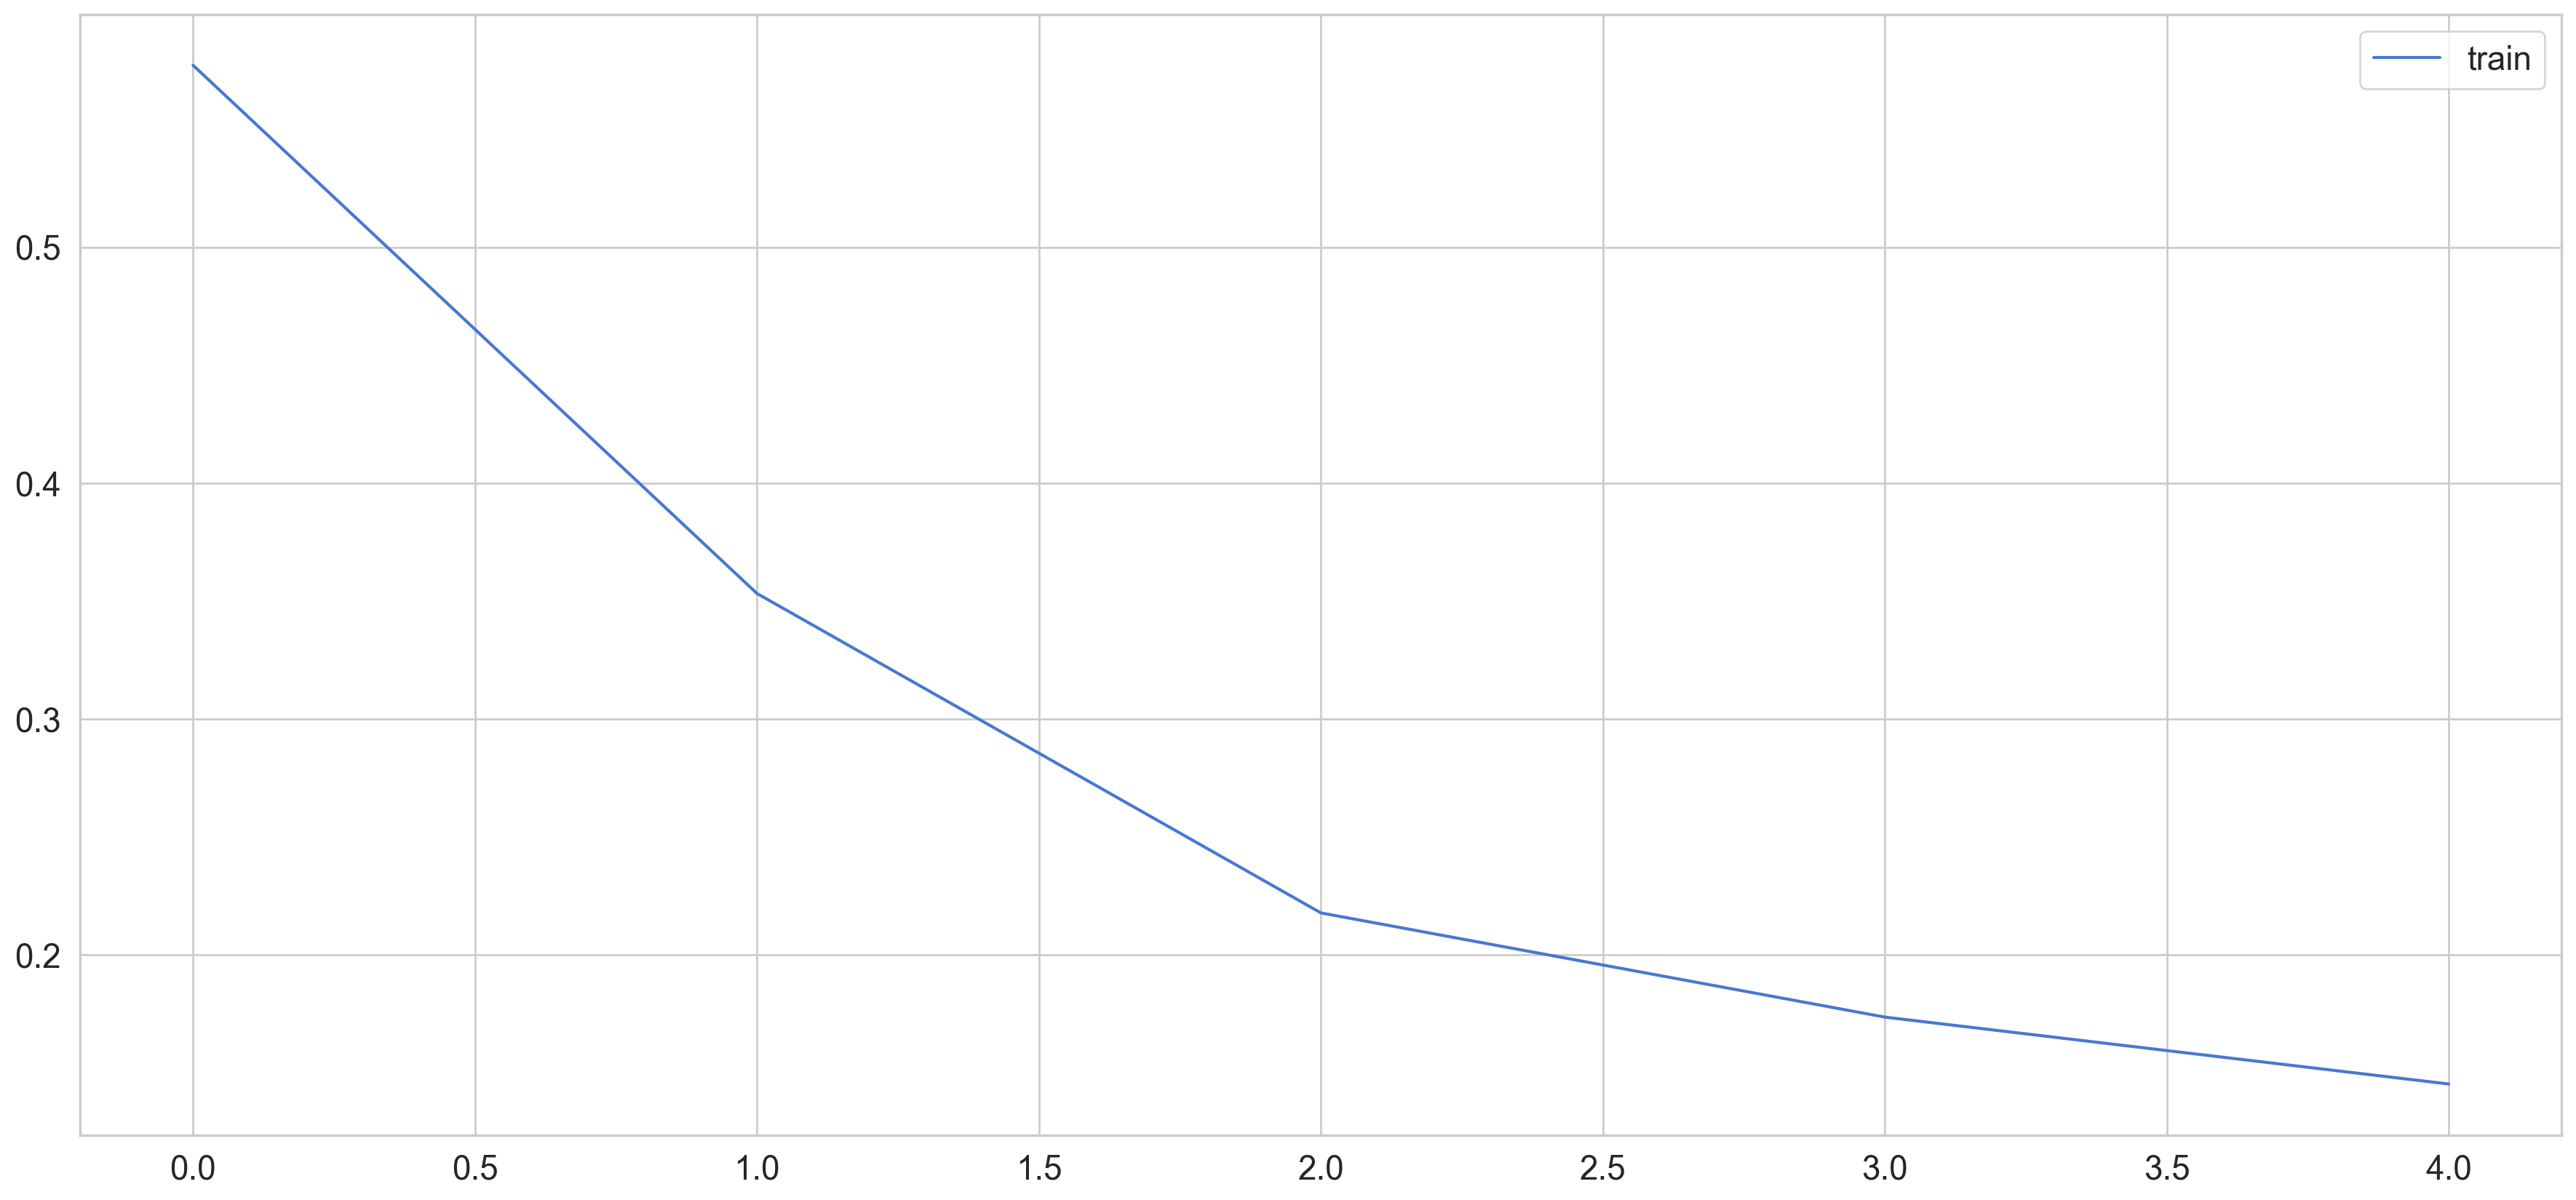

In [174]:
plt.plot(history.history['loss'], label='train')
plt.legend();

In [173]:
model.evaluate(X_test, y_test)

174/174 [==============================] - 4s 18ms/step - loss: 0.0799 - acc: 0.9789


[0.07985380291938782, 0.9788846969604492]